In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bax-for-xgb/df_bax_cleaned_to_view_outliers.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
df = pd.read_csv('/kaggle/input/bax-for-xgb/df_bax_cleaned_to_view_outliers.csv')
df

Date    Price     Open     High      Low       Vol.  Change %
0     2010-05-24  1482.42  1491.98  1491.98  1482.42   926980.0     -0.64
1     2010-05-25  1454.85  1482.42  1482.42  1454.85  1660000.0     -1.86
2     2010-05-26  1472.29  1456.50  1472.29  1454.85  1500000.0      1.20
3     2010-05-27  1453.82  1472.29  1478.07  1453.82  2480000.0     -1.25
4     2010-05-30  1455.16  1453.82  1462.04  1453.72  5910000.0      0.09
...          ...      ...      ...      ...      ...        ...       ...
3654  2025-03-05  1975.92  1980.24  1980.71  1974.02   818340.0     -0.21
3655  2025-03-06  1973.89  1975.92  1975.92  1973.89   294350.0     -0.10
3656  2025-03-23  1965.58  1962.09  1967.91  1955.49   611460.0     -0.42
3657  2025-03-25  1957.49  1951.62  1957.49  1942.88  1100000.0     -0.41
3658  2025-03-27  1951.36  1954.72  1954.72  1945.34   457910.0     -0.31

[3659 rows x 7 columns]

In [4]:
# --- 1. Data Preprocessing and Feature Engineering ---

# Convert 'Date' column to datetime objects and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
# Select only the 'Price' column for our forecasting task
data = df[['Price']].copy()

In [6]:
# Create lagged features to convert the time series problem into a supervised learning problem.
# We will use the prices from the last 1, 2, 3, 5, and 10 days to predict the current day's price.
lags = [1, 2, 3, 5, 10]
for lag in lags:
    data[f'Price_lag_{lag}'] = data['Price'].shift(lag)

In [7]:
# Drop any rows with NaN values that were created by the lagging process.
data.dropna(inplace=True)

In [8]:
# Define the feature set (X) and the target variable (y)
X = data.drop('Price', axis=1)
y = data['Price']

In [9]:
# --- 2. Data Splitting ---

# Split the data in a time-based manner.
# We'll use the first 80% for training and the last 20% for testing.
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [10]:
# Check the shapes of the splits
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (2919, 5), (2919,)
Testing data shape: (730, 5), (730,)


In [11]:
# --- 3. Model Training ---

# Initialize and train the XGBoost Regressor model.
# The 'n_estimators' parameter is similar to the number of trees in Random Forest.
# The 'objective' is set for regression.
# The 'eval_metric' helps monitor performance during training.
# random_state ensures reproducibility of results.
xg_model = xgb.XGBRegressor(
    n_estimators=500,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1
)

print("\nTraining XGBoost model...")
xg_model.fit(X_train, y_train,
             early_stopping_rounds=50,
             eval_set=[(X_test, y_test)],
             verbose=False)
print("Training complete.")


Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training complete.


In [12]:

# --- 4. Making Predictions ---

# Use the trained model to make predictions on the test data.
predictions = xg_model.predict(X_test)

In [13]:
# --- 5. Model Evaluation ---

# Calculate and print the evaluation metrics.
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 26.01
Root Mean Squared Error (RMSE): 33.26


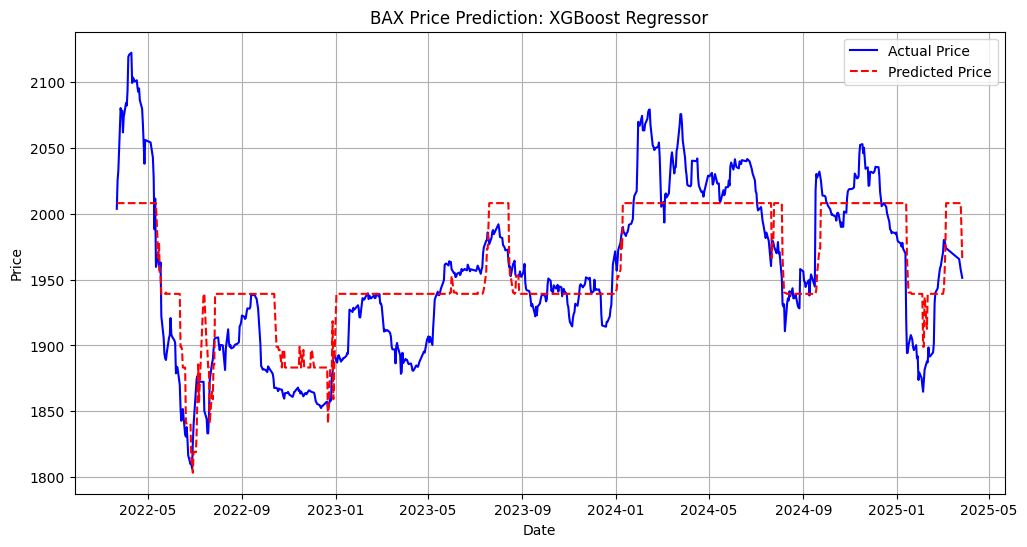

In [14]:
# --- 6. Visualization ---

# Plot the actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue')
plt.plot(y_test.index, predictions, label='Predicted Price', color='red', linestyle='--')
plt.title('BAX Price Prediction: XGBoost Regressor')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()